In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import preprocessing, feature_selection
%matplotlib inline
from IPython.display import Markdown, display

In [14]:
# Reading datasets

levels_df = pd.read_csv('https://raw.github.ccs.neu.edu/pantu16/cs6620_peiling_yuting_pedro/main/data/levels_fyi_salary_data.csv?token=AAABOLP6YVPNZECODFFF723CMZ6XM')



In [3]:
levels_df.dtypes

timestamp                   object
company                     object
level                       object
title                       object
totalyearlycompensation      int64
location                    object
yearsofexperience          float64
yearsatcompany             float64
tag                         object
basesalary                 float64
stockgrantvalue            float64
bonus                      float64
gender                      object
otherdetails                object
cityid                       int64
dmaid                      float64
rowNumber                    int64
Masters_Degree               int64
Bachelors_Degree             int64
Doctorate_Degree             int64
Highschool                   int64
Some_College                 int64
Race_Asian                   int64
Race_White                   int64
Race_Two_Or_More             int64
Race_Black                   int64
Race_Hispanic                int64
Race                        object
Education           

In [15]:
# Count of NaNs
levels_df.isna().sum()

timestamp                      0
company                        5
level                        119
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
tag                          854
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
otherdetails               22505
cityid                         0
dmaid                          2
rowNumber                      0
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Race                       40215
Education                  32272
dtype: int64

In [16]:
# 'Company': Drop NaN values since there is no way to infer company
levels_df.dropna(subset = ['company'], inplace=True)

# Refactor Companies' names to avoid duplication with misspelled names
# Reducing unique companies' names from 1631 to 1100
levels_df['std_company_name'] = levels_df['company'].map(lambda x: x.strip().lower().replace(" ", "_"))

# Replace NaN values in categorical features with "Unknown" to avoid dropping rows
features_to_replace = {'level': np.nan,
                   'tag': np.nan,
                    'gender': np.nan,
                    'otherdetails': np.nan,
                    'Race': np.nan,
                   'Education': np.nan}

replacement_values = {'level': 'Unknown_level',
                   'tag': 'Unknown_tag',
                    'gender': 'Unknown_gender',
                    'otherdetails': 'No_details',
                    'Race': 'Unknown_race',
                   'Education': 'Unknown_degree'}

levels_df.replace(to_replace=features_to_replace,
                  value=replacement_values,
                  inplace=True)

# 'dmid' replace NA values with 0
levels_df['dmaid'].fillna(0, inplace=True)

# 'gender' rename random value
levels_df['gender'] = levels_df['gender'].replace('Title: Senior Software Engineer','Unknown_gender')
levels_df['gender'] = levels_df['gender'].replace('Other','Other_gender')

# 'Race' rename
levels_df['Race'] = levels_df['Race'].replace('Two Or More','Two_Or_More_race')

# Count of NaNs
levels_df.isna().sum()

timestamp                  0
company                    0
level                      0
title                      0
totalyearlycompensation    0
location                   0
yearsofexperience          0
yearsatcompany             0
tag                        0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
otherdetails               0
cityid                     0
dmaid                      0
rowNumber                  0
Masters_Degree             0
Bachelors_Degree           0
Doctorate_Degree           0
Highschool                 0
Some_College               0
Race_Asian                 0
Race_White                 0
Race_Two_Or_More           0
Race_Black                 0
Race_Hispanic              0
Race                       0
Education                  0
std_company_name           0
dtype: int64

In [17]:
# 'basesalary' replace 0.0 values with median basesalary for years of experience
level_salary = levels_df.groupby('yearsofexperience')['basesalary'].median().reset_index()
base_salary_dict = level_salary.set_index('yearsofexperience').to_dict()['basesalary']

# check for 0.0 in basesalary column and use yearsofexperience to choose base salary from base_salary_dict
levels_df.loc[levels_df['basesalary'] == 0.0, 'basesalary'] = [base_salary_dict[x] for x in levels_df.loc[levels_df['basesalary'] == 0.0, 'yearsofexperience']]
zero_base_salary = levels_df[levels_df['basesalary'] == 0]
zero_base_salary


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,std_company_name


In [18]:
# Converting timestamp to datetime64

levels_df['timestamp'] = pd.to_datetime(levels_df['timestamp'])
levels_df.dtypes


timestamp                  datetime64[ns]
company                            object
level                              object
title                              object
totalyearlycompensation             int64
location                           object
yearsofexperience                 float64
yearsatcompany                    float64
tag                                object
basesalary                        float64
stockgrantvalue                   float64
bonus                             float64
gender                             object
otherdetails                       object
cityid                              int64
dmaid                             float64
rowNumber                           int64
Masters_Degree                      int64
Bachelors_Degree                    int64
Doctorate_Degree                    int64
Highschool                          int64
Some_College                        int64
Race_Asian                          int64
Race_White                        

### Feature Selection

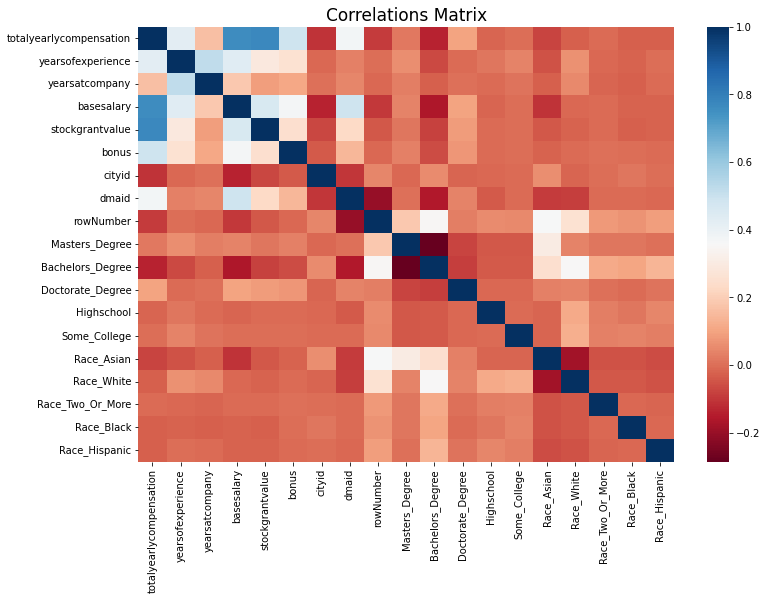

In [94]:
# Correlation Matrix

plt.figure(figsize=(12,8))
sns.heatmap(levels_df.corr(), cmap="RdBu")
plt.title("Correlations Matrix", size=17)
plt.show()

In [14]:
# Mutual Information with standardized numeric features and basesalary as target variable

# Select numeric features, drop base salary
numeric_features_df = levels_df.select_dtypes(include=np.number).copy()
# Drop totalyearlycompensation, bonu, stockgrantvalue since prediction will be made for basesalary
numeric_features_df.drop(labels=['basesalary', 'totalyearlycompensation', 'bonus', 'stockgrantvalue'], axis=1, inplace=True)
numeric_features_names = numeric_features_df.columns.tolist()

# Standardize
numeric_features_std = preprocessing.scale(numeric_features_df)

# Create a dataframe from ndnumpy array
numeric_std_df = pd.DataFrame(numeric_features_std, columns=numeric_features_names)

y_vector = levels_df['basesalary']
mutual_info_array = feature_selection.mutual_info_regression(X=numeric_std_df, y = y_vector)
mutual_info_array

# Building a dataframe with index = feature's name and column = 'MutualInfo'
mutual_info_df = pd.DataFrame(mutual_info_array, columns=['MutualInfo'], index=numeric_features_names)
mutual_info_df.sort_values(by='MutualInfo', ascending=False, inplace=True)
mutual_info_df


,MutualInfo
cityid,3.87e-01
dmaid,2.92e-01
yearsofexperience,2.27e-01
rowNumber,5.55e-02
yearsatcompany,5.47e-02
Bachelors_Degree,1.59e-02
Race_Asian,1.34e-02
Doctorate_Degree,6.66e-03
Race_White,6.34e-03
Masters_Degree,5.46e-03


In [116]:
# Encode Location, Since cityid is a relevant feature

# OPTION 0: hot encoding and use all columns
# levels_df = levels_df.join(pd.get_dummies(levels_df.location))

# OPTION 1: Binary Encoding for location

# Requires to install category_encoders run: pip install category_encoders
# Using Binary Encoding Reference: https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
# https://contrib.scikit-learn.org/category_encoders/index.html

# import category_encoders as ce

# binary_encoder = ce.BinaryEncoder(cols=['location'], return_df=True)
# levels_df = binary_encoder.fit_transform(levels_df)
# levels_df.drop(['cityid'], axis=1, inplace=True)

# levels_df.head(10)


In [15]:
# # Encode Location

# # OPTION 2: One hot encoding TOP X most frequent locations 
# location_threshold = 1000 # locations with more than 1000 instances
# top_locations = levels_df[levels_df['location'].isin(levels_df['location'].value_counts()[levels_df['location'].value_counts() > location_threshold].index)].location.unique()
# top_locations = top_locations.tolist()

# # Join locations
# levels_df = levels_df.join(pd.get_dummies(levels_df.location)[top_locations])
# levels_df.head()

# # Optional
# levels_df.drop(['cityid', 'location'], axis=1, inplace=True)


In [19]:
# # Encode Location

# OPTION 3: One hot encoding splitting by countries and cities in the US and selecting TOP X most frequent locations

# Encode location for different countries and for cities in the US
levels_df['country'] = levels_df.location.str.split(pat=',').apply(lambda x:x[-1][1:])
levels_df.loc[levels_df.country.str.len() == 2,'country'] = 'US'

# Encode Countries: Find countries with more than X instances
# TODO: decide which countries we want to keep
country_threshold = 1000 # countries with more than 1000 instances
top_countries = levels_df[levels_df['country'].isin(levels_df['country'].value_counts()[levels_df['country'].value_counts() > country_threshold].index)].country.unique()
top_countries = top_countries.tolist()

# Join countries
levels_df = levels_df.join(pd.get_dummies(levels_df.country)[top_countries])

# Encode US cities: Find cities with more than X instances 
# TODO: decide which US cities we want to keep
city_threshold = 1000 # cities with more than 1000 instances
top_us_cities = levels_df[levels_df['location'].isin(levels_df[levels_df['US']==1]['location'].value_counts()[levels_df[levels_df['US']==1]['location'].value_counts() > city_threshold].index)].location.unique()
top_us_cities = top_us_cities.tolist()

# Join US cities
levels_df = levels_df.join(pd.get_dummies(levels_df.location)[top_us_cities])

# Optional
levels_df.drop(['cityid', 'location', 'country'], axis=1, inplace=True)


In [20]:
# Encode Race
levels_df.drop(labels=['Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic'], axis=1, inplace=True)
#levels_df = levels_df.join(pd.get_dummies(levels_df.Race))

# Encode Gender
#levels_df = levels_df.join(pd.get_dummies(levels_df.gender))

# Optional
levels_df.drop(['Race', 'gender'], axis=1, inplace=True)


In [21]:
# Encode Title
stem_titles = ['Product Manager','Software Engineer',
'Software Engineering Manager',
 'Data Scientist',
 'Solution Architect',
 'Technical Program Manager',
 'Hardware Engineer',
 'Mechanical Engineer']

# TODO: choose only Stem_titles or ALL titles

levels_df = levels_df.join(pd.get_dummies(levels_df.title)[stem_titles])
# levels_df = levels_df.join(pd.get_dummies(levels_df.title))

# Optional
levels_df.drop(['title'], axis=1, inplace=True)


In [22]:
# Encode Education
levels_df.drop(labels=['Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College'], axis=1, inplace=True)

# OPTION 0: hot encoding and use all columns

# OPTION 1: Ordinal Encoding
education_scale_map = {"Unknown_degree":0, "Highschool":1, "Some College":2, "Bachelor's Degree":3, "Master's Degree":4, "PhD":5}
levels_df['Education'] = levels_df['Education'].replace(education_scale_map)

# OPTION 2: Hot encoding
# levels_df = levels_df.join(pd.get_dummies(levels_df.Education))
# levels_df.drop(['Education'], axis=1, inplace=True)


In [23]:
# Top Companies

levels_df['std_company_name'].value_counts()

amazon                8199
microsoft             5241
google                4363
facebook              3004
apple                 2047
                      ... 
truecar                  5
tyler_technologies       5
sas                      5
ping_identity            5
gemini                   5
Name: std_company_name, Length: 1100, dtype: int64

In [24]:
# Encode Company

# OPTION 0: hot encoding and use all columns
# levels_df = levels_df.join(pd.get_dummies(levels_df.std_company_name))

# OPTION 1: Binary Encoding
# Requires to install category_encoders run: pip install category_encoders
# Using Binary Encoding Reference: https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

# binary_encoder = ce.BinaryEncoder(cols=['std_company_name'], return_df=True)
# levels_df = binary_encoder.fit_transform(levels_df)

# OPTION 2: Hot encoding the TOP X most frequent companies
company_threshold = 100 # companies with more than X instances
top_companies = levels_df[levels_df['std_company_name'].isin(levels_df['std_company_name'].value_counts()[levels_df['std_company_name'].value_counts() > company_threshold].index)].std_company_name.unique()
top_companies = top_companies.tolist()
# Join top companies
levels_df = levels_df.join(pd.get_dummies(levels_df.std_company_name)[top_companies])

# # Optional
levels_df.drop(['company'], axis=1, inplace=True)


In [25]:
# OPTIONAL: Dropping values for not relevant/encoded features:
# 'tag', 'otherdetails', 'dmaid', 'rowNumber' -> not relevant or replicable from user inputs

levels_df.drop(['tag', 'otherdetails', 'dmaid', 'rowNumber'], axis=1, inplace=True)


In [26]:
# Current available columns
print(levels_df.columns.tolist())

['timestamp', 'level', 'totalyearlycompensation', 'yearsofexperience', 'yearsatcompany', 'basesalary', 'stockgrantvalue', 'bonus', 'Education', 'std_company_name', 'US', 'United Kingdom', 'India', 'Canada', 'San Francisco, CA', 'Seattle, WA', 'Sunnyvale, CA', 'Mountain View, CA', 'Redmond, WA', 'Menlo Park, CA', 'Cupertino, CA', 'New York, NY', 'San Jose, CA', 'Palo Alto, CA', 'Austin, TX', 'Boston, MA', 'Santa Clara, CA', 'Product Manager', 'Software Engineer', 'Software Engineering Manager', 'Data Scientist', 'Solution Architect', 'Technical Program Manager', 'Hardware Engineer', 'Mechanical Engineer', 'oracle', 'ebay', 'amazon', 'apple', 'microsoft', 'salesforce', 'facebook', 'uber', 'google', 'netflix', 'pinterest', 'linkedin', 'adobe', 'intel', 'lyft', 'yelp', 'airbnb', 'sap', 'vmware', 'twitter', 'cisco', 'dropbox', 'ibm', 'walmart_labs', 'twilio', 'qualcomm', 'tesla', 'expedia', 'yahoo', 'intuit', 'bloomberg', 'yandex', 'capital_one', 'workday', 'splunk', 'samsung', 'autodesk', 

## Models


In [27]:
from sklearn.model_selection import train_test_split

y = levels_df["basesalary"]
X = levels_df.drop(["basesalary"], axis=1)
X = X.drop(["timestamp"], axis=1)
X = X.drop(["level"], axis=1)
X = X.drop(["std_company_name"], axis=1)
X = X.drop(["totalyearlycompensation"], axis=1)
X = X.drop(["stockgrantvalue"], axis=1)
X = X.drop(["bonus"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
# Changing options to display full result
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

# Print np arrays without truncation
np.set_printoptions(threshold=np.inf)

# 2 decimals for operations in pandas
pd.set_option('precision', 2)

X.dtypes.size

106

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
import math

display(r2_score(y_test, y_pred))
display(math.sqrt(mean_squared_error(y_test, y_pred)))

0.6627310002680658

30832.755025698698

In [30]:
from sklearn.tree import DecisionTreeRegressor 

dt_reg = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)

display(r2_score(y_test, y_pred))
display(math.sqrt(mean_squared_error(y_test, y_pred)))

0.4888412317036913

37957.88690908005

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=400, 
    max_depth=5, 
    learning_rate=0.1, 
    min_samples_split=3).fit(X_train, y_train)

y_pred = gbr.predict(X_test)

display(r2_score(y_test, y_pred))
display(math.sqrt(mean_squared_error(y_test, y_pred)))

0.7182979205066513

28178.582759524506

### Model Tuning: Grid Search

In [40]:
X_train.columns

Index(['yearsofexperience', 'yearsatcompany', 'Education', 'US',
       'United Kingdom', 'India', 'Canada', 'San Francisco, CA', 'Seattle, WA',
       'Sunnyvale, CA',
       ...
       'visa', 'walmart', 'epam_systems', 'morgan_stanley', 'amd', 'doordash',
       'instacart', 'lockheed_martin', 'pwc', 'bytedance'],
      dtype='object', length=113)

In [33]:
from sklearn.model_selection import GridSearchCV

In [43]:
# Tuning tree-based parameters
# param_test1 = {'n_estimators':range(100,320,20)}  # Results: n_estimators:240 , learning_rate: 0.30, r2: 0.7088227587772149
# param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)} # Results: max_depth:11 , min_samples_split: 600, r2: 0.7157821007669771
# param_test3 = {'min_samples_leaf':range(30,71,10)} # Results: min_samples_leaf: 40, r2: 0.7157859305727758
# param_test4 = {'max_features':range(10,107,5)} # Results: max_features: 50, r2: 0.7179848026241465
# param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]} # Results: subsample: 0.80, r2: 0.7179848026241465


# gsearch = GridSearchCV(estimator = GradientBoostingRegressor(max_depth=5, 
#     learning_rate=0.3, 
#     min_samples_split=400,
#     min_samples_leaf = 50,
#     max_features='sqrt',
#     subsample=0.8), 
# param_grid = param_test1, scoring='r2',n_jobs=4, cv=5)

# gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3,
#     n_estimators=240,
#     max_features='sqrt',
#     subsample=0.8,
#     random_state=10), 
# param_grid = param_test2, scoring='r2',n_jobs=4, cv=5)

# gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3,
#     n_estimators=240,
#     max_depth = 11,
#     max_features='sqrt',
#     min_samples_split = 600,
#     subsample=0.8,
#     random_state=10), 
# param_grid = param_test3, scoring='r2',n_jobs=4, cv=5)

# gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3,
#     n_estimators=240,
#     max_depth = 11,
#     min_samples_leaf = 40,
#     min_samples_split = 600,
#     subsample=0.8,
#     random_state=10), 
# param_grid = param_test4, scoring='r2',n_jobs=4, cv=5)

# gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3,
#     n_estimators=240,
#     max_depth = 11,
#     min_samples_leaf = 40,
#     max_features = 50,
#     min_samples_split = 600,
#     random_state=10), 
# param_grid = param_test5, scoring='r2',n_jobs=4, cv=5)

# Try (learning_rate, n_estimators) = (0.15, 480, r2:0.718617044459145), (0.07,900,r2:) 
gbr_tuned = GradientBoostingRegressor(learning_rate=0.07,
    n_estimators=900,
    max_depth = 11,
    min_samples_leaf = 40,
    max_features = 50,
    min_samples_split = 600,
    subsample = 0.80,
    random_state=10)

# Fit model
# gsearch.fit(X_train,y_train)
gbr_tuned.fit(X_train,y_train)

# Print best params
# display(gsearch.best_params_, gsearch.best_score_)

# Predict
# y_pred = gsearch.predict(X_test)
y_pred = gbr_tuned.predict(X_test)
display(r2_score(y_test, y_pred))
display(math.sqrt(mean_squared_error(y_test, y_pred)))


0.7193480441129927

28126.011930603043

## Dump Models


In [47]:
from joblib import dump, load

dump(gbr_tuned, 'basesalary_gbr_tuned.joblib')

# from google.colab import files
# files.download('basesalary_gbr_tuned.joblib')

['basesalary_gbr_tuned.joblib']